# A toy example of variational inference with normalizing flow (using the VI class)

In [ ]:
!pip install tqdm torchvision tensorboardX

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import optim
import numpy as np

from matplotlib import pyplot as plt

batch_size = 128
epochs = 2000
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
from pixyz.distributions import CustomProb, Normal, TransformedDistribution
from pixyz.models import VI
from pixyz.flows import PlanarFlow, FlowList
from pixyz.utils import print_latex

In [3]:
def plot_samples(points):
    X_LIMS = (-4, 4)
    Y_LIMS = (-4, 4)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)
    ax.set_xlabel("p(z)")

    plt.show()

In [4]:
import torch
x_dim = 2


def log_prob(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    
    return -u


p = CustomProb(log_prob, var=["z"])

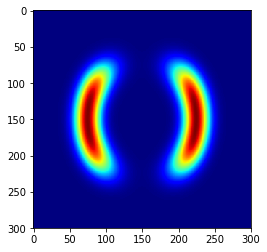

In [5]:
def plot_density(p):

    X_LIMS = (-4, 4)
    Y_LIMS = (-4, 4)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z = np.c_[x1, x2]
    z = torch.FloatTensor(z)

    density_values = p.prob().eval({"z":z}).data.numpy().reshape(shape)
    plt.imshow(density_values, cmap='jet')
    plt.show()
    
plot_density(p)

In [6]:
# prior
prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["x"], features_shape=[x_dim], name="prior").to(device)

In [7]:
# flow
f = FlowList([PlanarFlow(x_dim) for _ in range(32)])

In [8]:
# transformed distribution (x -> f -> z)
q = TransformedDistribution(prior, f, var=["z"], name="q").to(device)
print(q)
print_latex(q)

Distribution:
  q(z) = q(z=f_{flow}(x))
Network architecture:
  TransformedDistribution(
    name=q, distribution_name=TransformedDistribution,
    var=['z'], cond_var=[], input_var=[], features_shape=torch.Size([2])
    (prior): Normal(
      name=prior, distribution_name=Normal,
      var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([2])
      (loc): torch.Size([1, 2])
      (scale): torch.Size([1, 2])
    )
    (flow): FlowList(
      (0): PlanarFlow(in_features=2, constraint_u=False)
      (1): PlanarFlow(in_features=2, constraint_u=False)
      (2): PlanarFlow(in_features=2, constraint_u=False)
      (3): PlanarFlow(in_features=2, constraint_u=False)
      (4): PlanarFlow(in_features=2, constraint_u=False)
      (5): PlanarFlow(in_features=2, constraint_u=False)
      (6): PlanarFlow(in_features=2, constraint_u=False)
      (7): PlanarFlow(in_features=2, constraint_u=False)
      (8): PlanarFlow(in_features=2, constraint_u=False)
      (9): PlanarFlow(in_features=2,

<IPython.core.display.Math object>

In [9]:
model = VI(p, q, optimizer=optim.Adam, optimizer_params={"lr":1e-2})
print(model)
print_latex(model)

Distributions (for training): 
  p(z), q(z) 
Loss function: 
  - mean \left(\mathbb{E}_{q(z)} \left[\log p(z) - \log q(z) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.01
      weight_decay: 0
  )


<IPython.core.display.Math object>

Epoch: 0 Test loss: 3.6156


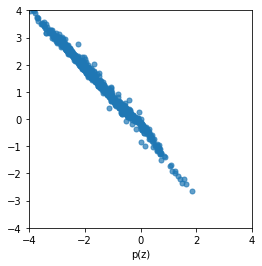

Epoch: 100 Test loss: -0.6462


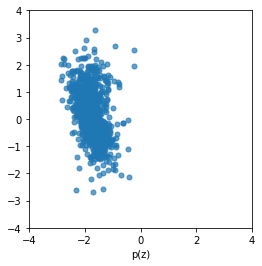

Epoch: 200 Test loss: -0.7124


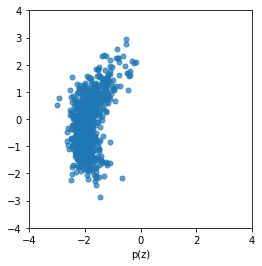

Epoch: 300 Test loss: 0.0419


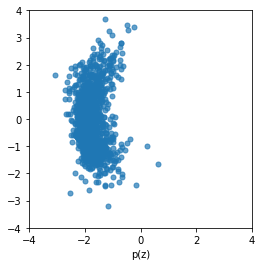

Epoch: 400 Test loss: -0.8025


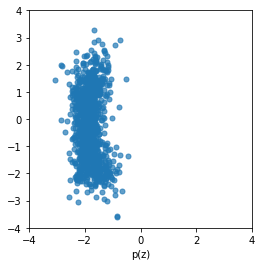

Epoch: 500 Test loss: -0.5928


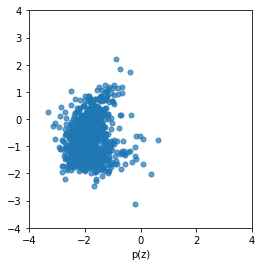

Epoch: 600 Test loss: -1.0833


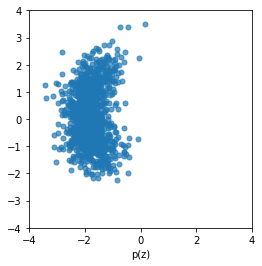

Epoch: 700 Test loss: -0.6238


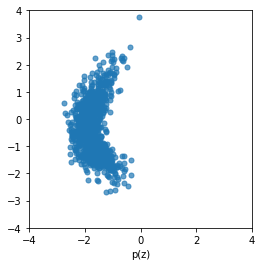

Epoch: 800 Test loss: -1.3810


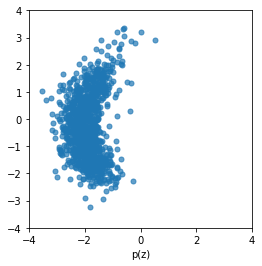

Epoch: 900 Test loss: -1.4098


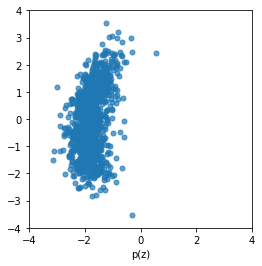

Epoch: 1000 Test loss: -0.5109


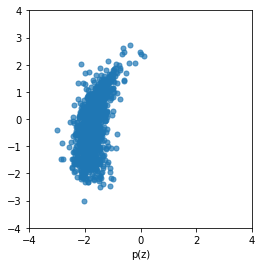

Epoch: 1100 Test loss: -0.7680


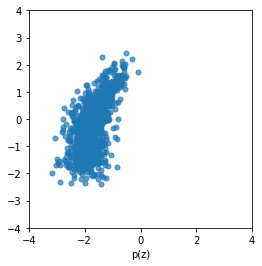

Epoch: 1200 Test loss: -0.9632


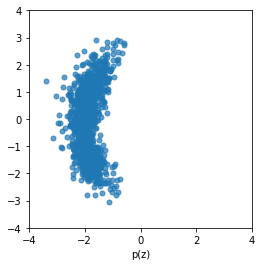

Epoch: 1300 Test loss: -1.3732


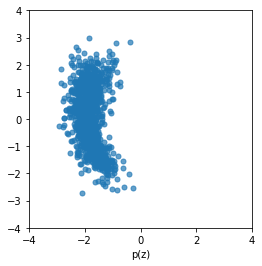

Epoch: 1400 Test loss: -2.4732


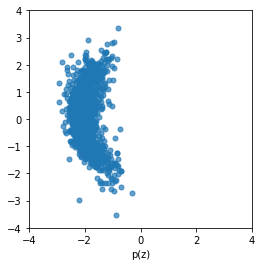

Epoch: 1500 Test loss: -1.3717


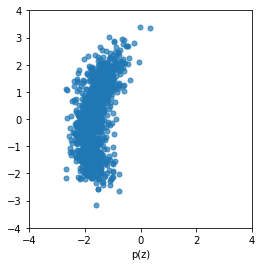

Epoch: 1600 Test loss: -0.9830


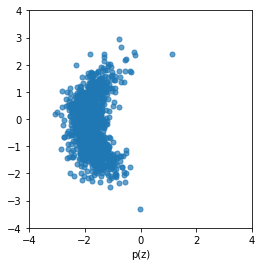

Epoch: 1700 Test loss: -0.9445


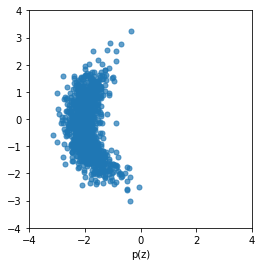

Epoch: 1800 Test loss: -0.7659


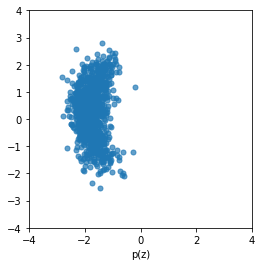

Epoch: 1900 Test loss: -0.2299


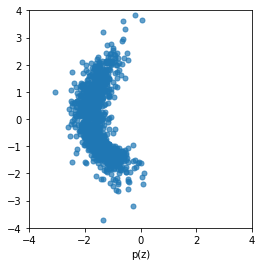

In [10]:
for epoch in range(epochs):
    loss = model.train(batch_size=batch_size)

    if epoch % 100 == 0:
        print('Epoch: {} Test loss: {:.4f}'.format(epoch, loss))
    
        loss = model.test(batch_n=batch_size)
        samples = q.sample(batch_n=1000)
        plot_samples(samples["z"].cpu().data.numpy())